In [2]:
%pip install awswrangler --quiet
from re import sub 
from functools import partial
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import boto3
import awswrangler as wr
import pandas as pd
session = boto3.Session()


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# you need to change this `s3_output` to a directory/S3 bucket that you have permissions to access
s3_output='s3://universityose-bucket/yvlcmb/awswrangler/'

fetch = partial(wr.athena.read_sql_query, 
                database='universityose_db', 
                boto3_session=session,
                s3_output=s3_output)

cols = {
    "flightid": "flightid",
    "times_seconds":"seconds",
    "engines_computations_e1torque": "e1torque",
    "engines_computations_e2torque": "e2torque",
    "flightstate_altitudes_gpsaltitude":"altitude",
    "rotors_mainrotorrpmpercentage": "rotor_rpm",
    "flightstate_rates_climbordescentrate":"climb_descent"
}

def create_sql_from_flightid(flightid, cols=cols):
    sql_query = ''.join((
        'SELECT ', 
        *[f'{k} AS {v}, ' for k, v in cols.items()], 
        "FROM flight_details ", 
        f"WHERE flightid = '{flightid}'"))
    return sub(', FROM', ' FROM', sql_query)


def fetch_flight(flightid: str) -> 'DataFrame':
    """Query a flight from Athena using a flightid,
    return the result as  a Pandas Dataframe, sorted
    by seconds, with vertical acceleration calculated"""
    fix = fetch(create_sql_from_flightid(flightid))
    df = fix.sort_values('seconds').reset_index()
    assert df.seconds.min() == df.at[0, 'seconds'] and df.seconds.max() == df.iloc[-1].seconds
    df['vert_accel'] = (
        (df.climb_descent - df.climb_descent.shift(1)) / 
        (df.seconds - df.seconds.shift(1))
    )
    return df[df.columns[1:]]

In [4]:
# this dictionary contains flightids as keys and tuples of integers representing the ranges of rows where low-g occurred as values
# ...using (None) as a second item in the value if there are no other ranges is an ugly work-around that needs to be updated 

flights_and_events= {
    "31dcb8_20230216T191746_20230216T192349": (
        (10600, 11000), 
        (None)
    ),
    "31dcb8_20230615T200220_20230615T201354": (
        (19500, 19700), 
        (None)
    ),
    "31dcb8_20230216T151400_20230216T152827": (
        (34800, 34925), 
        (28350, 28700)
    ),
    "31dcb8_20221020T164314_20221020T170607": (
        (7400, 7700),
        (16150, 16300),
        (23900, 24300),
        (36050, 36200), 
        (50500, 51000)
    ),
    "31dcb8_20221006T134902_20221006T141008": (
        (6120, 6190),
        (43000, 43150), 
        (45600, 45825), 
        (46950, 47075),
        (55550, 55675),
        (51100, 51275)
    ),
    "31dcb8_20230615T193227_20230615T200139": (
        (51100, 51400), 
        (33600, 33950), 
        (13700, 13900), 
        (26425, 26600), 
        (20350, 20500), 
        (44850, 44925),
        (61100, 61250)
    ), 
    "31dcb8_20230615T160258_20230615T163145": (
        (10150, 10550),
        (12800, 13100),
        (14600, 14900),
        (15300, 15600),
        (18400, 18725),
        (19090, 19200),
        (22250, 22500),
        (23040, 23250),
        (43800, 44300), 
        (44800, 45200)
    ),
    "31dcb8_20230615T145234_20230615T152543": (
        (64800, 65100), 
        (None)
    ),
    "31dcb8_20221006T131452_20221006T134556": (
        (22500, 22900), 
        (47350, 47550), 
        (50600, 50700),
        (77300, 77600)
    ),
    "31dcb8_20221020T211929_20221020T220157": (
        (20200, 20800),
        (24725, 24825),
        (28550, 28650),
        (30400, 30700), 
        (41500, 41700)
    ),
    "31dcb8_20221006T145214_20221006T153158": (
        (41250, 41500), 
        (46300, 46700), 
        (36600, 36800), 
        (39180,39400)
    ),
    "31dcb8_20230126T205028_20230126T205649": (
        (14200, 14450), 
        (None)
    ),
    "31dcb8_20230615T133129_20230615T135220": (
        (29350, 29600), 
        (31550, 31700), 
        (34350, 34500)
    )
}

### Query Athena for flights as dataframes, label rows in the dataframes as low-G

In [5]:
frames = [fetch_flight(flightid) for flightid in flights_and_events.keys()]

first = lambda seq: seq[0]; last = lambda seq: seq[-1]

for frame in frames: 
    frame['label'] = 0
    ranges = flights_and_events.get(frame.at[0, "flightid"])
    for r in ranges: 
        if r: 
            for i in range(first(r), last(r)+1):
                frame.at[i, 'label'] = 1
                
event_count = sum(1 for val in flights_and_events.values() for v in val)
label_count = sum([frame.label.sum() for frame in frames])
not_label_count = sum([len(frame[frame['label']==0]) for frame in frames])
total_count = sum([len(frame) for frame in frames])

print(f'There are {event_count} low-G events from {len(flights_and_events.keys())} flights')
print(f'There are {label_count} labeled rows from a total of {total_count}.')
print(f'\tLabeled rows: {round((label_count/total_count) * 100, 2)}%')
print(f'\tNon-labeled rows: {round((not_label_count/total_count) * 100, 2)}%')            

There are 54 low-G events from 13 flights
There are 12460 labeled rows from a total of 780457.
	Labeled rows: 1.6%
	Non-labeled rows: 98.4%


### Pre-process data for model training

In [10]:
scaler = StandardScaler()
sample = frames[3:7]
combined = pd.concat(sample) 
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
    'label',
]
combined = combined[keep].dropna()
df = combined.reset_index(drop=True)
# define independent variables and dependent variable
X = df.drop('label', axis=1)
y = df['label']

# create training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=1)

X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

cross_validate = partial(GridSearchCV, 
                         scoring='recall', 
                         refit=True, 
                         verbose=3, 
                         n_jobs=-1, 
                         return_train_score=True)

In [7]:
df.describe()

climb_descent     vert_accel      rotor_rpm       e1torque  \
count  260146.000000  260146.000000  260146.000000  260146.000000   
mean        8.025655       0.006724     106.377213      57.259867   
std      1300.389279     296.480089       3.532516      26.186281   
min    -13390.920000   -7371.365470      62.287000      -6.534000   
25%      -176.462250     -36.571510     106.940000      37.945000   
50%         0.001000      -0.129033     107.013000      52.130000   
75%       239.965250      27.285582     107.130000      64.962750   
max      7764.597000    6938.658357     111.410000     160.906000   

            e2torque       altitude          label  
count  260146.000000  260146.000000  260146.000000  
mean       57.259867    2596.811432       0.026497  
std        26.186281    3673.066764       0.160607  
min        -6.534000       1.240000       0.000000  
25%        37.945000      72.770000       0.000000  
50%        52.130000     463.470000       0.000000  
75%        64.962750    6191.042500       0.000000  
max       160.906000   13428.710000       1.000000

### Model 1: Random Forest

In [7]:
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [None],
    'criterion' :['gini', 'entropy']
}
clf = cross_validate(estimator=ensemble.RandomForestClassifier(random_state=1, n_jobs=-1), param_grid=param_grid)
clf.fit(X_train, y_train)
randomforest_cv = pd.DataFrame(clf.cv_results_)
randomforest_cv.to_csv('randomforest-res.csv')
randomforest_cv.sort_values('rank_test_score').iloc[0]

mean_fit_time                                                 58.376951
std_fit_time                                                     0.9714
mean_score_time                                                 0.73774
std_score_time                                                  0.02032
param_criterion                                                 entropy
param_max_depth                                                    None
param_max_features                                                 auto
param_n_estimators                                                  150
params                {'criterion': 'entropy', 'max_depth': None, 'm...
split0_test_score                                              0.984587
split1_test_score                                              0.987296
split2_test_score                                              0.986401
split3_test_score                                              0.982774
split4_test_score                                              0

In [15]:
print(randomforest_cv.sort_values('rank_test_score').iloc[0].params)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}


### Model 2: Stochastic gradient descent linear model

In [13]:
from sklearn import svm 
from sklearn.linear_model import SGDClassifier

In [5]:
cross_validate = partial(GridSearchCV, scoring='recall', refit=True, n_jobs=-1, return_train_score=True)

NameError: name 'partial' is not defined

In [10]:
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01], 
}
clf = cross_validate(SGDClassifier(random_state=1, n_jobs =-1), param_grid=param_grid)
clf.fit(X_train, y_train)
sgd_cv = pd.DataFrame(clf.cv_results_)
sgd_cv.sort_values('rank_test_score').iloc[0]
sgd_cv.to_csv("sgd-res.csv")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

In [68]:
print(sgd_cv.sort_values('rank_test_score').iloc[0].params)

{'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'l2'}


### Model 3: Support vector machine classifier

In [11]:
param_grid = {
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

In [14]:
clf = cross_validate(estimator=svm.SVC(random_state=1), param_grid=param_grid)
clf.fit(X_train, y_train)
svc_cv = pd.DataFrame(clf.cv_results_)
svc_cv.sort_values('rank_test_score').iloc[0]
svc_cv.to_csv('svc-res.csv')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END gamma=scale, kernel=linear;, score=(train=0.436, test=0.440) total time= 1.5min
[CV 3/5] END gamma=scale, kernel=linear;, score=(train=0.433, test=0.450) total time= 1.6min
[CV 1/5] END gamma=scale, kernel=poly;, score=(train=0.463, test=0.465) total time= 5.0min
[CV 3/5] END gamma=scale, kernel=poly;, score=(train=0.463, test=0.463) total time= 4.7min
[CV 5/5] END gamma=scale, kernel=poly;, score=(train=0.471, test=0.465) total time= 4.2min
[CV 2/5] END gamma=scale, kernel=rbf;, score=(train=0.643, test=0.640) total time= 1.4min
[CV 4/5] END gamma=scale, kernel=rbf;, score=(train=0.637, test=0.651) total time= 2.6min
[CV 5/5] END gamma=scale, kernel=rbf;, score=(train=0.645, test=0.628) total time= 1.4min
[CV 1/5] END gamma=scale, kernel=sigmoid;, score=(train=0.242, test=0.222) total time= 2.3min
[CV 3/5] END gamma=scale, kernel=sigmoid;, score=(train=0.241, test=0.251) total time= 9.7min
[CV 5/5] END gamma=scal

NameError: name 'svc' is not defined

[CV 2/5] END gamma=scale, kernel=linear;, score=(train=0.434, test=0.431) total time= 1.6min
[CV 4/5] END gamma=scale, kernel=linear;, score=(train=0.432, test=0.419) total time= 1.6min
[CV 5/5] END gamma=scale, kernel=linear;, score=(train=0.439, test=0.440) total time= 1.6min
[CV 2/5] END gamma=scale, kernel=poly;, score=(train=0.467, test=0.468) total time= 4.6min
[CV 4/5] END gamma=scale, kernel=poly;, score=(train=0.465, test=0.466) total time= 4.4min
[CV 1/5] END gamma=scale, kernel=rbf;, score=(train=0.637, test=0.646) total time= 2.8min
[CV 3/5] END gamma=scale, kernel=rbf;, score=(train=0.644, test=0.635) total time= 7.2min
[CV 2/5] END gamma=scale, kernel=sigmoid;, score=(train=0.237, test=0.257) total time= 2.1min
[CV 4/5] END gamma=scale, kernel=sigmoid;, score=(train=0.240, test=0.236) total time= 9.8min
[CV 1/5] END gamma=auto, kernel=linear;, score=(train=0.436, test=0.440) total time= 1.5min
[CV 2/5] END gamma=auto, kernel=linear;, score=(train=0.434, test=0.431) total 

In [16]:
svc_cv.to_csv('svc-res.csv')

In [15]:
print(svc_cv.sort_values('rank_test_score').iloc[0].params)

{'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
print(svc_cv.head())

In [ ]:
2 + 2

### Model 4: Linear support vector machine classifier

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1.0, 2.0],
}
clf = cross_validate(estimator=svm.LinearSVC(random_state=1, max_iter=1500, dual=False), param_grid=param_grid)
clf.fit(X_train, y_train)
lsvc_cv = pd.DataFrame(clf.cv_results_)
lsvc_cv.sort_values('rank_test_score').iloc[0]
lsvc_cv.to_csv('lsvc-res.csv')

In [13]:
print(lsvc_cv.sort_values('rank_test_score').iloc[0].params)

{'C': 0.5, 'penalty': 'l2'}


### Model 5: artificial neural network / multilayer perceptron classifier

In [8]:
from sklearn.neural_network import MLPClassifier

In [ ]:
param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'], 
    'solver': ['lbfgs', 'sgd', 'adam'], 
    'max_iter': [200, 300],
    'learning_rate': [
}
clf = cross_validate(estimator=MLPClassifier(random_state=1), param_grid=param_grid) 
clf.fit(X_train, y_train)
ann_cv = pd.DataFrame(clf.cv_results_)
ann_cv.to_csv('ann-res.csv') 
ann_cv.sort_values('rank_test_score').iloc[0]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [42]:
print(ann_cv.sort_values('rank_test_score').iloc[0].params) # train 78.01% test 77.56%

{'activation': 'relu', 'solver': 'adam'}


### Gradient boost

In [ ]:
param_grid = {'loss': ['deviance', 'exponential'],
              'n_estimators': [50, 100, 150],
              'learning_rate': [1.0, 0.1, 0.01],
              'criterion': ['friedman_mse']}
clf = cross_validate(estimator=ensemble.GradientBoostingClassifier(random_state=1), param_grid=param_grid) 
clf.fit(X_train, y_train)
grad_cv = pd.DataFrame(clf.cv_results_)
grad_cv.sort_values('rank_test_score').iloc[0]
grad_cv.to_csv('gradientboost-res.csv')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
print(grad_cv.sort_values('rank_test_score').iloc[0].params)

### Adaboost

In [ ]:
param_grid= {'n_estimators': [50, 100, 150], 
             'algorithm': ['SAMME', 'SAMME.R'], 
             'learning_rate':[0.01, 0.1, 1.0]}
clf = cross_validate(estimator=ensemble.AdaBoostClassifier(random_state=1), param_grid=param_grid) 
clf.fit(X_train, y_train)
adaboost_cv = pd.DataFrame(clf.cv_results_)

In [54]:
adaboost_cv.sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
17      35.504895      2.790726         0.671961        0.082333   
16      24.334457      0.179791         0.489461        0.005402   
15      12.504851      0.152884         0.263126        0.001171   
8       33.714379      0.121856         0.365136        0.004101   
7       23.145703      0.354899         0.257615        0.003243   

   param_algorithm param_learning_rate param_n_estimators  \
17         SAMME.R                 1.0                150   
16         SAMME.R                 1.0                100   
15         SAMME.R                 1.0                 50   
8            SAMME                 1.0                150   
7            SAMME                 1.0                100   

                                               params  split0_test_score  \
17  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...           0.727108   
16  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...           0.680870   
15  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...           0.602901   
8   {'algorithm': 'SAMME', 'learning_rate': 1.0, '...           0.615594   
7   {'algorithm': 'SAMME', 'learning_rate': 1.0, '...           0.593835   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
17           0.715971  ...         0.703666        0.015024                1   
16           0.682396  ...         0.663950        0.019096                2   
15           0.626134  ...         0.616251        0.007826                3   
8            0.639746  ...         0.614803        0.017761                4   
7            0.616152  ...         0.593221        0.017371                5   

    split0_train_score  split1_train_score  split2_train_score  \
17            0.716844            0.720988            0.705056   
16            0.670596            0.680644            0.648152   
15            0.595330            0.623073            0.633190   
8             0.624122            0.634859            0.606212   
7             0.598050            0.608341            0.583768   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
17            0.701202            0.711403          0.711099         0.007285  
16            0.671050            0.669009          0.667890         0.010684  
15            0.632283            0.612106          0.619196         0.014156  
8             0.635910            0.613013          0.622823         0.011747  
7             0.601451            0.588075          0.595937         0.008929  

[5 rows x 23 columns]

In [51]:
print(adaboost_cv.sort_values('rank_test_score').iloc[0].params)

{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 150}


In [58]:
adaboost_cv.to_csv('adaboost-res.csv')

In [6]:
scaler = StandardScaler()
combined = pd.concat(frames) 
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
    'label',
]
combined = combined[keep].dropna()
df = combined.reset_index(drop=True)
# define independent variables and dependent variable
X = df.drop('label', axis=1)
y = df['label']

# create training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=1)

X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)



In [8]:
len(X_train)

624355

In [9]:
len(X_test)

156089

### Validation

In [10]:
from sklearn import ensemble

In [15]:
params = {'criterion': 'entropy', 
          'max_depth': None, 
          'max_features': 'log2', 
          'n_estimators': 150, 
          'n_jobs':-1, 
         'random_state':1}

In [17]:
clf = ensemble.RandomForestClassifier(**params)

In [18]:
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=1)

In [19]:
from sklearn import metrics

In [20]:
y_train_pred = clf.predict(X_train) 
print(*zip(
    ('train accuracy: ',
     'train recall: ', 
     'train precision: ',
     'train f1: '),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')
print('-'*len("('train_precision: ', 0.999)"))
y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy: ', 1.0)
('train recall: ', 1.0)
('train precision: ', 1.0)
('train f1: ', 1.0)
----------------------------
('test accuracy:', 0.998)
('test recall:', 0.901)
('test precision:', 0.983)
('test f1:', 0.94)


#### Feed the champion model a new unlabeled flight

In [47]:
flight_ids = fetch("SELECT DISTINCT(flightid) FROM flight_details WHERE month='10' AND year='2023'").flightid.tolist()

In [48]:
flight_ids

['31dcb8_20231012T194212_20231012T202735']

In [50]:
df = fetch_flight(flight_ids[0])

In [ ]:
clf.fit

In [52]:
scaler = StandardScaler()
#combined = pd.concat(frames) 
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
]
temp = df[keep].dropna() 
X_train = scaler.fit(temp).transform(temp)

In [53]:
y_train_pred = clf.predict(X_train) 

In [59]:
y_train_pred[1]

0

In [62]:
out = temp.copy()

In [63]:
out['prediction'] = y_train_pred

In [65]:
out[out.prediction==1]

climb_descent  vert_accel  rotor_rpm  e1torque  e2torque  altitude  \
74696         -96.518 -513.050489    107.346    52.929    52.929   2135.14   
74697        -106.518 -500.000477    107.351    52.820    52.820   2134.94   
74698        -116.493 -398.998478    107.357    52.716    52.716   2134.74   
74699        -129.157 -436.688995    107.362    52.612    52.612   2134.48   
74700        -143.392 -677.860098    107.368    52.475    52.475   2134.18   
...               ...         ...        ...       ...       ...       ...   
119919      -1163.101  -50.368279    107.515    30.516    30.516    342.56   
119920      -1163.887  -34.173910    107.505    30.488    30.488    342.20   
119921      -1164.639  -28.923051    107.496    30.463    30.463    341.78   
119922      -1165.289  -28.260867    107.486    30.436    30.436    341.31   
119923      -1165.677  -18.476271    107.475    30.408    30.408    340.89   

        prediction  
74696            1  
74697            1  
74698            1  
74699            1  
74700            1  
...            ...  
119919           1  
119920           1  
119921           1  
119922           1  
119923           1  

[754 rows x 7 columns]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

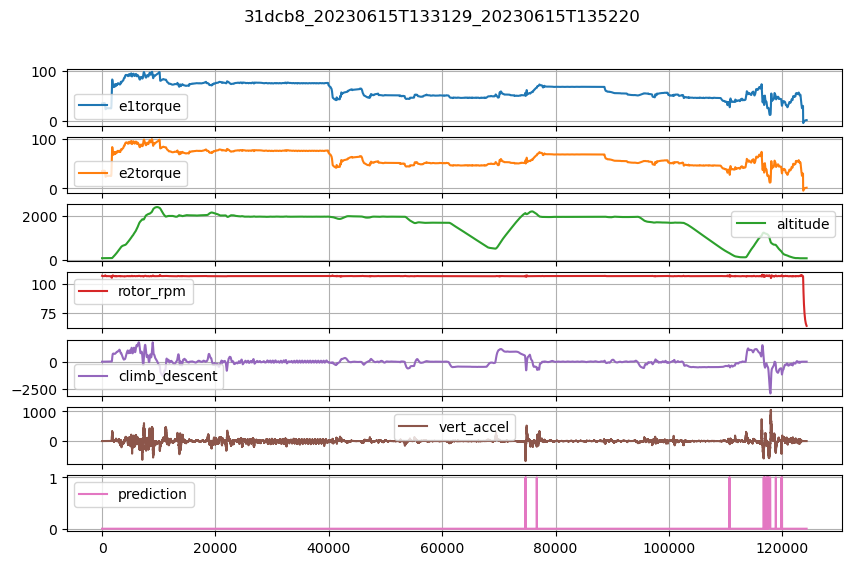

In [68]:

# this graphic shows the labeled sections that contain probably low-G events (values of 1 on the bottom subplot)
plot_these = ['e1torque', 'e2torque', 'altitude', 'rotor_rpm', 'climb_descent', 'vert_accel', 'prediction']
out[plot_these].plot(subplots=True, grid=True, figsize=(10,6), title=frame.at[0, 'flightid'])

In [69]:
def plot_suspect(frame, rows):
    """Zoom in to specific rows of a dataframe to plot
    
    Parameters
    ----------
    rows: a tuple/list/set indicating start & stop range of rows to plot
    
    Example
    -------
    >>> plot_suspect(frame=df, rows=(43800, 44500))
    """
    frame[rows[0]:rows[1]][plot_these].plot(
    title=frame.at[0, 'flightid'],
    subplots=True,
    grid=True,
    figsize=(10,6))

In [ ]:
plot_suspect(out, 60_000, 120_000)